# Advanced Neural Networks: Deep Learning For Spatial Analysis

# Assignment #2 — Product Recommendation using Content based image retrieval via feature extraction

# Rhichard Koh

# Step 1: Load the Pre-trained ResNet Model

In [3]:
import os
import torch
import numpy as np
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image

# Use ResNet50 without the final classification layer
resnet50 = models.resnet50(pretrained=True)
resnet50 = torch.nn.Sequential(*list(resnet50.children())[:-1])  # Remove the classification layer
resnet50.eval()  # Set the model to evaluation mode

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [6]:
# Check if Cuda is available
torch.cuda.is_available()

True

In [7]:
# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50 = resnet50.to(device)

# Step 2: Define Image Preprocessing Function

In [8]:
# Transform the image to match the input required by ResNet50
transform = transforms.Compose([
    transforms.Resize((224, 224)),# Resizes the image to match the input required by ResNet50
    transforms.ToTensor(), # Converts the image to a PyTorch tensor. Scales pixel intensity values from [0, 255] to [0.0, 1.0].
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ImageNet mean & std
])

In [9]:
def load_and_preprocess_image(img_path):
    # Load an image from the given path and apply the necessary transformations
    img = Image.open(img_path).convert('RGB') # Ensure the image has 3 color channels (RGB)
    return transform(img).unsqueeze(0).to(device)  # Add batch dimension and move to device (CPU/GPU)

# Step 3: Extract Feature Vectors from Images

In [10]:
image_folder = '/kaggle/input/fashion-product-images-dataset/fashion-dataset/images'
feature_vectors = []

with torch.no_grad():  # Disable gradient computation to speed up and save memory
    for img_file in os.listdir(image_folder):
        img_path = os.path.join(image_folder, img_file)
        img_tensor = load_and_preprocess_image(img_path) # Preprocess the image
        features = resnet50(img_tensor).flatten()  # Extract and flatten the feature vector
        feature_vectors.append(features.cpu().numpy()) # Convert to numpy array and store

feature_vectors = np.array(feature_vectors)

In [11]:
feature_vectors = np.array(feature_vectors) # Convert list of feature vectors to a numpy array

# Save feature vectors to a file
np.save('feature_vectors.npy', feature_vectors)

In [17]:
# Load the feature_vectors
feature_vectors = np.load('feature_vectors.npy')

# Step 4: Build the Recommendation System by Similarity Measurement

In [22]:
from sklearn.metrics.pairwise import cosine_similarity

def get_similar_images(query_vector, feature_vectors, top_n=5):
    # Calculate cosine similarity between the query vector and all feature vectors
    similarities = cosine_similarity([query_vector], feature_vectors)
    # Sort the indices based on similarity in descending order
    sorted_indices = np.argsort(similarities[0])[::-1]  # Sort by similarity in descending order
    return sorted_indices[:top_n] # Return the indices of the top n similar images

## Example usage


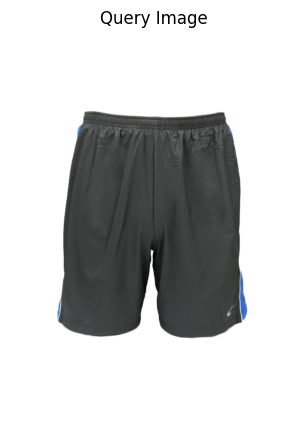

Top 5 similar images' index: [24782 27338 10096  1161  2549]


In [28]:
query_image_path = '/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/10004.jpg' # Query image path
query_image_tensor = load_and_preprocess_image(query_image_path) # Preprocess the query image
query_img = Image.open(query_image_path).convert('RGB') # Load the query image in RGB format
plt.figure(figsize=(5, 5)) # Set the figure size
plt.imshow(query_img) # Display the query image
plt.axis('off') # Hide the axes
plt.title('Query Image') # Set the title for the query image
plt.show() # Show the query image

# Extract the feature vector for the query image
with torch.no_grad():
    query_image_vector = resnet50(query_image_tensor).flatten().cpu().numpy() # Extract and flatten the query vector

# Get top 5 similar images
similar_indices = get_similar_images(query_image_vector, feature_vectors)
print(f"Top 5 similar images' index: {similar_indices}")

# Step 5: Visualize the Similar Images

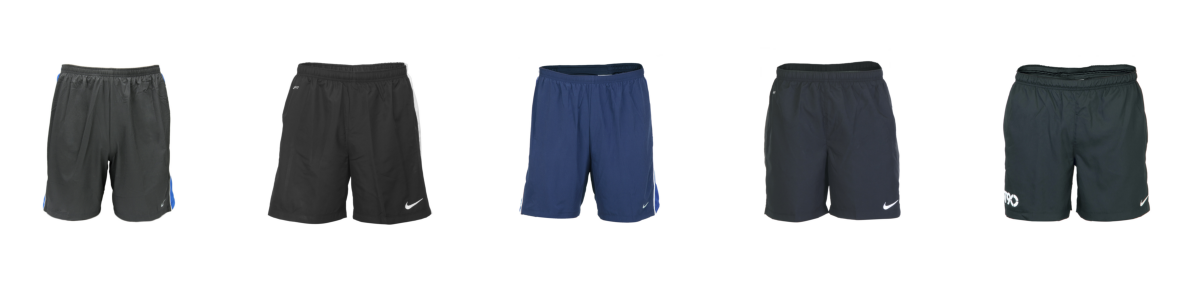

In [24]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def show_images(indices):
    # Display the images corresponding to the given indices
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(indices):
        img_path = os.path.join(image_folder, os.listdir(image_folder)[idx]) # Get the image path
        img = Image.open(img_path).convert('RGB') # Load the image in RGB format
        plt.subplot(1, len(indices), i + 1) # Create a subplot for each image
        plt.imshow(img) # Show the image
        plt.axis('off') # Hide the axes
    plt.show()

# Show the similar images
show_images(similar_indices)